# Variational Quantum Eigensolver (VQE)

### VQE Implementation. Step 1: Map classical to quantum

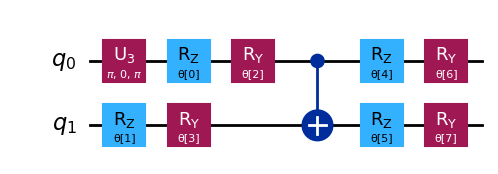

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1,8)).tolist()
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2, 
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1
)
ansatz = reference_circuit.compose(variational_form)


def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
    
    Returns:
        flaot: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

ansatz.decompose().draw("mpl")


In [8]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

We can use this cost function to calculate optimal parameters

In [10]:
# Scipy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method='COBYLA')

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.99999997890921
       x: [ 1.743e+00  9.451e-01  1.571e+00 -7.557e-05  1.923e+00
            1.219e+00  6.222e-01  6.221e-01]
    nfev: 130
   maxcv: 0.0

### Step 2: Optimize problem for quantum execution

We will select the least-busy backend, and import the necessary components form qiskit_ibm_runtime.



In [11]:
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, Session, EstimatorOptions, QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)

### Step 3: Execute using Qiskit Runtime Primitives

In [ ]:
x0 = np.ones(8)

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10000
)

with Session(backend=backend) as session:
    estimator = EstimatorV2(mode=session, options=estimator_options)

    result = minimize(cost_func_vqe, x0, args=(isa_ansatz, isa_observable, estimator), method="COBYLA", options={'maxiter': 200, 'disp': True})
session.close()
print(result)

### Step 4: Post-process, return result in classical format

We can see that the minimization routine successfully terminated, meaning we reached the default tolerance of the COBYLA classical optimizer. If we require a more precise result, we can specify a smaller tolerance. This may indeed be the case, since the result was several percent off compared to the result obtained by the simulator above.

The value of x obtained is the current best guess for the parameters that minimize the cost function. If iterating to obtain a higher precision, those values should be used in place of the x0 initially used (a vector of ones).

Finally, we note that the function was evaluated 96 times in the process of optimization. That might be different from the number of optimization steps, since some optimizers require multiple function evaluations in a single step, such as when estimating a gradient.

# Subspace Search VQE (SSVQE)

You will be re-constructing SSVQE's cost function in the assessment, but we have the following snippet to motivate your solution:

In [16]:
import numpy as np

def cost_func_ssvqe(params, initialized_ansatz_list, weights, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

     Parameters:
         params (ndarray): Array of ansatz parameters
         initialized_anastz_list (list QuantumCircuit): Array of initialised ansatz with reference
         weights (list): List of weights
         ansatz (QuantumCircuit): Parameterized ansatz circuit
         hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
         estimator (Estimator): Estimator primitive instance

     Returns:
         float: Weighted energy estimate
     """

    energies = []

    # Define SSVQE

    weighted_energy_sum = np.dot(energies, weights)
    return weighted_energy_sum

# Variational Quantum Deflation (VQD)

For this implementation, we'll create a function for an overlap penalty. This penalty will be used in the cost function at each iteration. This process will be repeated for each excited state

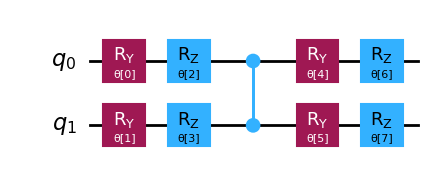

In [18]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw("mpl")

First, we'll setup a function that calculates the state fidelity -- a percentage of overlap between two states that we'll use as a penalty for VQD:

In [24]:
import numpy as np

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler):

    def create_fidelity_circuit(circuit_1, circuit_2):

        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
                
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

It's time to write VQD's cost function. As before when we calculated only the ground state, we will determine the lowest energy state using the Estimator primitive. However, as described above, we will now add a penalty term to ensure orthogonality of higher-energy states. That is, for each new excited state, a penalty is added for any overlap between the current variational state and the lower-energy eigenstates already found.

In [25]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

Note especially that the cost function above refers to the calculate_overlaps function, which actually creates a new quantum circuit. If we want to run on real hardware, that new circuit must also be transpiled, hopefully in an optimal way, to run on the backend we select. Note that transpilation has been built in to the calculate_overlaps or cost_func_vqd functions. Feel free to try modifying the code yourself to build in this additional (and conditional) transpilation - but this will also be done for you in the next lesson.

In this lesson, we will run the VQD algorithm using the Statevector Sampler and Statevector Estimator:

In [ ]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
sampler = Sampler()
estimator = Estimator()

# We will introduce an observable to be estimated. In the next lesson we will add some physical context to this, 
# like the excited state of a molecule. It may be helpful to think of this observable as the Hamiltonian of a system 
# that can have excited states, even though this observable has not been chosen to match any particular molecule or atom.

from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

# Here, we set the total number of states we wish to calculate (ground state and excited states, k), and the penalties 
# (betas) for overlap between statevectors that should be orthogonal. The consequences of choosing betas to be too high 
# or too low will be explored a bit in the next lesson. For now, we will simply use those provided below. We will start 
# by using all zeros as our parameters. In your own calculations, you may want to use more clever starting parameters 
# based on your knowledge of the system or on previous calculations.

k = 3
betas = [33,33,33]
x0 = np.zeros(8)

# We can now run the calculation:

from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable), method="COBYLA", options={'maxiter': 200,})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9999999677919624
       x: [-2.692e-05 -4.859e-05  0.000e+00  0.000e+00  4.146e-05
           -7.207e-05  0.000e+00  0.000e+00]
    nfev: 77
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5186584958304787
       x: [-2.408e-01  1.480e+00  4.433e-01 -2.611e-01  3.019e+00
            1.630e+00  1.564e-01  4.769e-02]
    nfev: 92
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 6.329886709879643
       x: [ 6.282e-01  1.678e+00  3.872e-02 -3.064e-01  1.428e-01
            1.492e+00  1.107e+00  9.427e-01]
    nfev: 98
   maxcv: 0.0


: 

The values we obtained from the cost function are approximately -1.00, -1.15, and 6.32. The important thing about these results is that the function values are increasing. If we had obtained a first excited state that is lower in energy than our initial (what actually happened here), unconstrained calculation of the ground state, that would have indicated an error somewhere in our code.

The values of x are the parameters that yielded a statevector corresponding to each of these costs/energies.

Finally, we note that all three minimizations converged to within the default tolerance of the classical optimizer (here COBYLA). They required 77, 92, and 98 function evaluations, respectively.